In [92]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import mne
from tqdm import tqdm
from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery
import warnings
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
paradigm = MotorImagery(n_classes=4)
mne.set_config("MNE_DATA", "/home/hice1/mchen439/scratch/mne_data")
mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")
print(mne.get_config())

Choosing from all possible events


{'MNE_DATA': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_ALEXEEG_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_BNCI_PATH': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_EEGBCI_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_FAKEDATASET-IMAGERY-10-2--60-60--120-120--FAKE1-FAKE2-FAKE3--C3-CZ-C4_PATH': '/tmp/tmpwour6ucf', 'MNE_DATASETS_FAKEVIRTUALREALITYDATASET-P300-21-1--60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60--120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120--TARGET-NONTARGET--C3-CZ-C4_PATH': '/tmp/tmpvhx98uwa', 'MNE_DATASETS_GIGADB_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_LEE2019-MI_PATH': '/home/hice1/mchen439/mne

/tmp/ipykernel_97727/3997935127.py:3: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")


In [12]:
datasetMotorImagery = BNCI2014_001()
subjects = [1]
with warnings.catch_warnings(action="ignore"):
	X, y, metadata = paradigm.get_data(dataset=datasetMotorImagery, subjects=subjects)
print(metadata.columns)
print(np.unique(y))

Index(['subject', 'session', 'run'], dtype='object')
['feet' 'left_hand' 'right_hand' 'tongue']


In [17]:
y_encoded = np.zeros(y.shape)
for idx in range(y.shape[0]):
	if y[idx] == "tongue":
		y_encoded[idx] = 0
	elif y[idx] == "right_hand":
		y_encoded[idx] = 1
	elif y[idx] == "left_hand":
		y_encoded[idx] = 2
	else:
		y_encoded[idx] = 3

print(X.shape, y.shape, type(X), type(y), print(metadata.shape), print(type(metadata)))

(576, 3)
<class 'pandas.core.frame.DataFrame'>
(576, 22, 1001) (576,) <class 'numpy.ndarray'> <class 'numpy.ndarray'> None None


In [18]:
tongue_trials = X[y_encoded == 0, :,:]
print(tongue_trials.shape)

(144, 22, 1001)


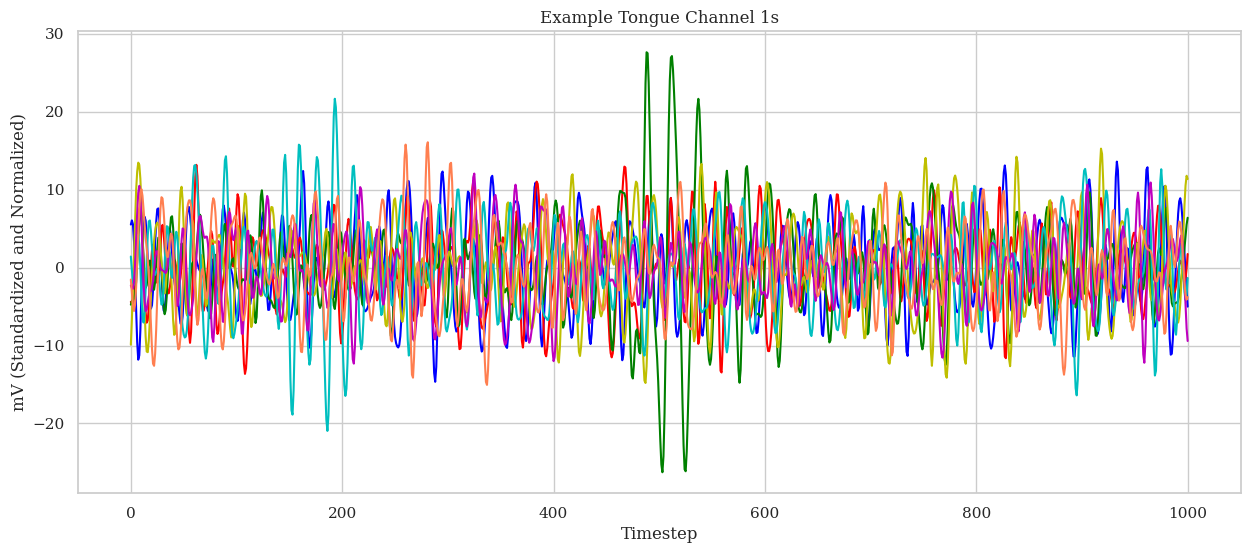

In [21]:
plt.figure(figsize=(15,6))
plt.plot(tongue_trials[0, 0, :], c="b")
plt.plot(tongue_trials[1, 0, :], c="r")
plt.plot(tongue_trials[2, 0, :], c="g")
plt.plot(tongue_trials[3, 0, :], c="y")
plt.plot(tongue_trials[4, 0, :], c="c")
plt.plot(tongue_trials[5, 0, :], c="m")
plt.plot(tongue_trials[6, 0, :], c="coral")

plt.title("Example Tongue Channel 1s")
plt.xlabel("Timestep")
plt.ylabel("mV (Standardized and Normalized)")
plt.show()

In [38]:
print(tongue_trials[:, :, 0].shape)

(144, 22)


In [59]:
# Analyzing Channel 0
dist_matrix = distance_matrix(tongue_trials[:, :, 0], tongue_trials[:, :, 0])
print(dist_matrix.shape)
minval = np.min(dist_matrix[np.nonzero(dist_matrix)])
maxval = np.max(dist_matrix[np.nonzero(dist_matrix)])
print(minval, maxval)
print(dist_matrix[np.nonzero(dist_matrix)].mean())
print(dist_matrix[np.nonzero(dist_matrix)].std())
close_pairs = np.argwhere((dist_matrix < dist_matrix[np.nonzero(dist_matrix)].mean()) & (dist_matrix != 0))
print(close_pairs.shape)

close_pairs = list(zip(close_pairs.T[0], close_pairs.T[1]))
pairs = set(close_pairs)
close_pairs = set((a,b) if a<=b else (b,a) for a,b in pairs)
print(len(close_pairs))

(144, 144)
4.423347211683858 106.66598150556365
29.12447787748345
15.141197136012513
(12092, 2)
6046


In [61]:
dlist = [[] for t in range(tongue_trials.shape[2])]
for i, j in close_pairs:
	for t in range(tongue_trials.shape[2]):
		dlist[t].append(np.log(np.linalg.norm(tongue_trials[i, :, t] - tongue_trials[j, :, t])))

In [67]:
max_exponent = np.zeros(tongue_trials.shape[2])
average_exponent = np.zeros(tongue_trials.shape[2])

for i in range(len(dlist)):
	if len(dlist[i]):
		max_exponent[i] = max(dlist[i])
		average_exponent[i] = sum(dlist[i])/len(dlist[i])

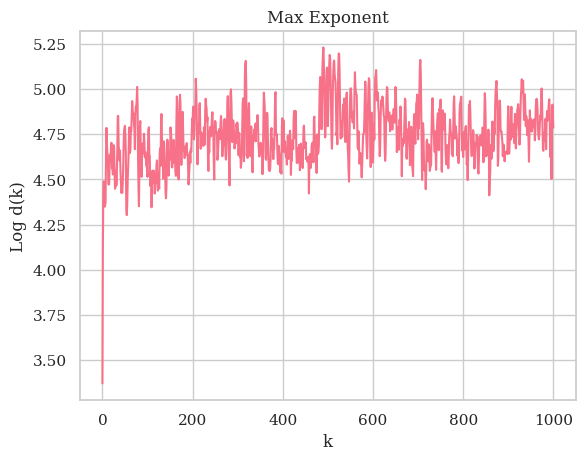

In [72]:
plt.xlabel('k')
plt.ylabel('Log d(k)')
plt.title('Max Exponent')
plt.plot(max_exponent)

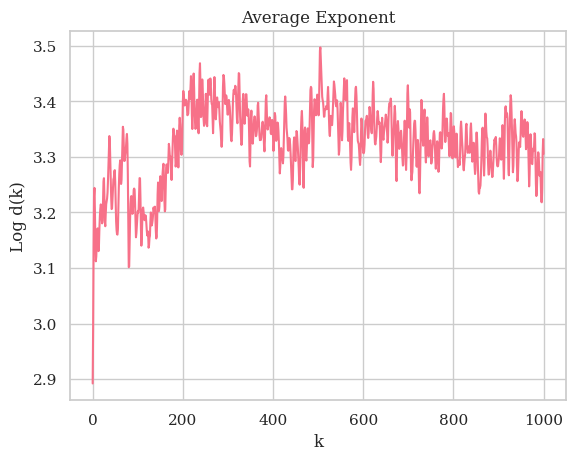

In [71]:
plt.xlabel('k')
plt.ylabel('Log d(k)')
plt.title('Average Exponent')
plt.plot(average_exponent)

100%|██████████| 6046/6046 [02:37<00:00, 38.42it/s]


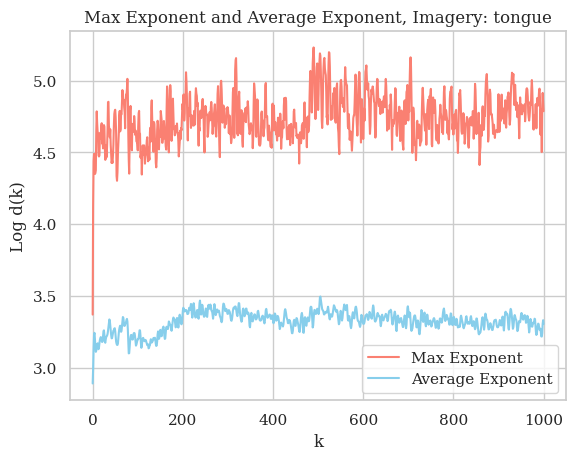

100%|██████████| 6032/6032 [02:45<00:00, 36.34it/s]


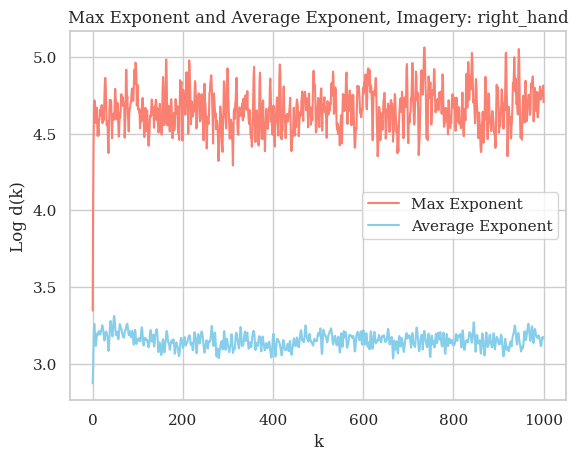

100%|██████████| 6086/6086 [02:37<00:00, 38.70it/s]


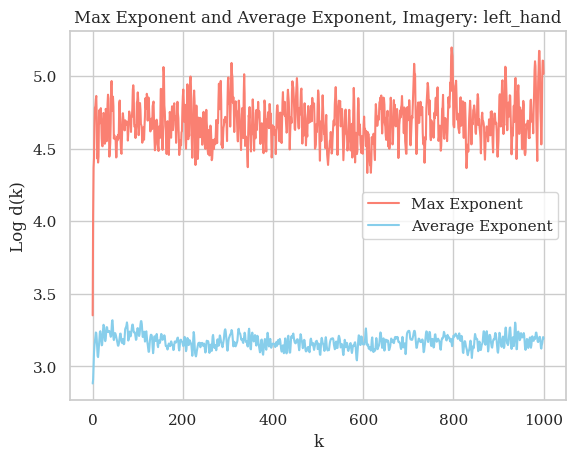

100%|██████████| 5942/5942 [02:48<00:00, 35.21it/s]


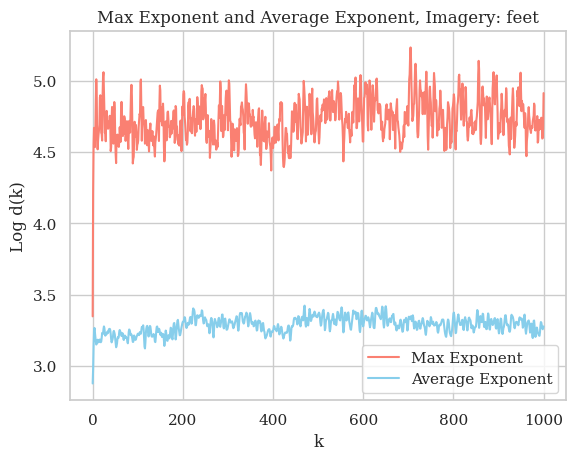

In [94]:
scheme = {0: 'tongue', 1: 'right_hand', 2: 'left_hand', 3: 'feet'}
for imagery in range(4):
	trials = X[y_encoded == imagery, :,:]

	dist_matrix = distance_matrix(trials[:, :, 0], trials[:, :, 0])
	dm = dist_matrix[np.nonzero(dist_matrix)]
	minval = np.min(dm)
	maxval = np.max(dm)
	close_pairs = np.argwhere((dist_matrix < dm.mean()) & (dist_matrix != 0))
	close_pairs = list(zip(close_pairs.T[0], close_pairs.T[1]))
	pairs = set(close_pairs)
	close_pairs = set((a,b) if a<=b else (b,a) for a,b in pairs)

	dlist = [[] for t in range(trials.shape[2])]
	for i, j in tqdm(close_pairs):
		for t in range(trials.shape[2]):
			dlist[t].append(np.log(np.linalg.norm(trials[i, :, t] - trials[j, :, t])))

	max_exponent = np.zeros(tongue_trials.shape[2])
	average_exponent = np.zeros(tongue_trials.shape[2])

	for i in range(len(dlist)):
		if len(dlist[i]):
			max_exponent[i] = max(dlist[i])
			average_exponent[i] = sum(dlist[i])/len(dlist[i])

	plt.xlabel('k')
	plt.ylabel('Log d(k)')
	plt.title(f'Max Exponent and Average Exponent, Imagery: {scheme[imagery]}')
	plt.plot(max_exponent, c='salmon', label="Max Exponent")
	plt.plot(average_exponent, c='skyblue', label="Average Exponent")
	plt.legend()
	plt.show()